In [1]:
import os
os.chdir('/home/jennifer.badolato/watttime-python-client-aer-algo')

import numpy as np
import pandas as pd
import datetime
import random
import pytz
from datetime import datetime, timedelta
import random
from watttime import WattTimeHistorical, WattTimeForecast
import os
import optimizer.dataset as od
from evaluation.config import MOER_REGION_LIST
import evaluation.eval_framework as evu
import optimizer.s3 as s3u

import seaborn as sns
import matplotlib.pyplot as plt

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

## Generate a year of data
- two random dates per week
- max date is now() - 1
- duplicate dates removed

In [2]:
dates_2023 = evu.generate_random_dates(2023)
dates_2024 = evu.generate_random_dates(2024)

distinct_date_list = dates_2023 + dates_2024

distinct_date_list = [
    pd.Timestamp(date)
    for date in pd.date_range(start, end, freq="d").values
]

In [3]:
dfs = evu.execute_synth_data_process(distinct_date_list, number_of_users=1000)

100%|██████████| 1000/1000 [00:12<00:00, 78.84it/s]


In [4]:
s3 = s3u.s3_utils()
key = '20240715_1k_synth_users.csv'
s3.store_csvdataframe(dataframe=dfs, file=key)

Successful S3 put_object response. Status - 200


## Distributions

In [4]:
dfs.uncharged.value_counts()

uncharged
False    12270
True      2730
Name: count, dtype: int64

In [5]:
dfs["length_plugged_in"].describe()

count    15000.000000
mean     24992.491288
std       8059.692972
min         12.672562
25%      19585.371842
50%      25053.451556
75%      30478.047431
max      57016.667543
Name: length_plugged_in, dtype: float64

In [6]:
(dfs["length_plugged_in"] < 0).value_counts()

length_plugged_in
False    15000
Name: count, dtype: int64

Text(0.5, 1.0, 'length_plugged_in')

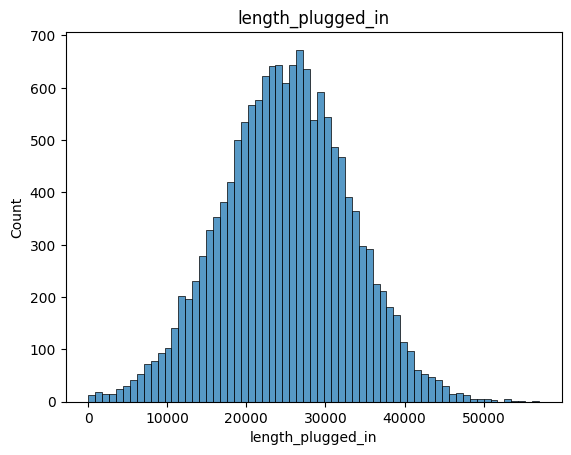

In [7]:
sns.histplot(dfs["length_plugged_in"]).set_title("length_plugged_in")

In [8]:
dfs["total_seconds_to_95"].describe()

count    15000.000000
mean     19172.669259
std      12900.715922
min       1522.219378
25%       9289.986704
50%      15590.661619
75%      26361.823048
max      81173.726494
Name: total_seconds_to_95, dtype: float64

Text(0.5, 1.0, 'total_seconds_to_95')

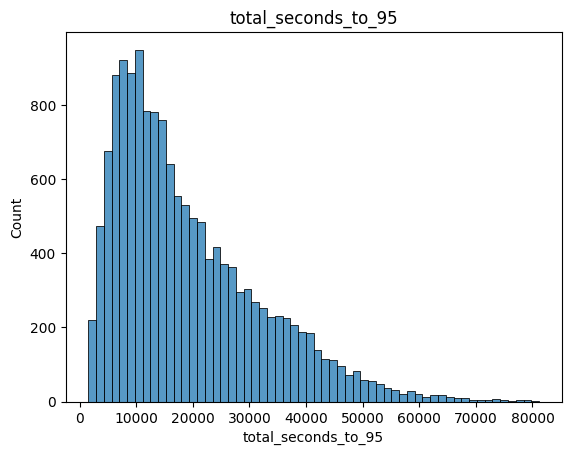

In [9]:
sns.histplot(dfs["total_seconds_to_95"]).set_title("total_seconds_to_95")

Text(0.5, 1.0, 'final_perc_charged')

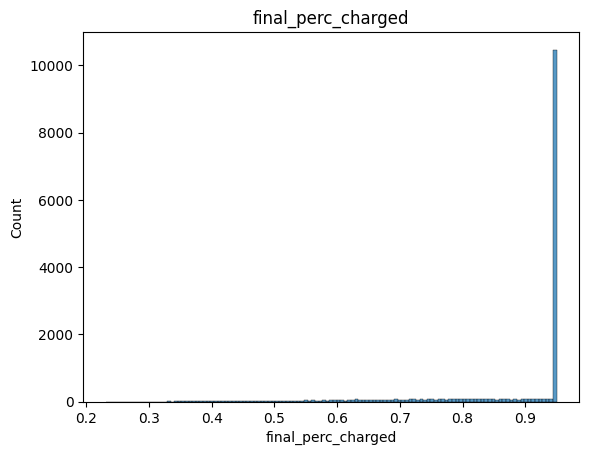

In [10]:
sns.histplot(dfs["final_perc_charged"]).set_title("final_perc_charged")

Text(0.5, 1.0, 'total_capacity')

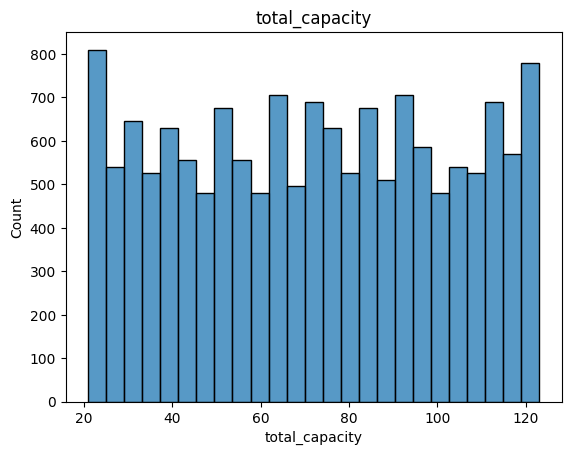

In [11]:
sns.histplot(dfs["total_capacity"]).set_title("total_capacity")

Text(0.5, 1.0, 'charged_kWh_actual')

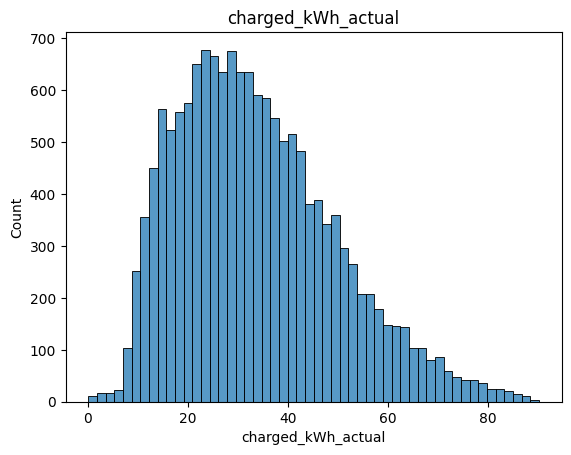

In [12]:
sns.histplot(dfs["charged_kWh_actual"]).set_title("charged_kWh_actual")

Text(0.5, 1.0, 'power_output_rate')

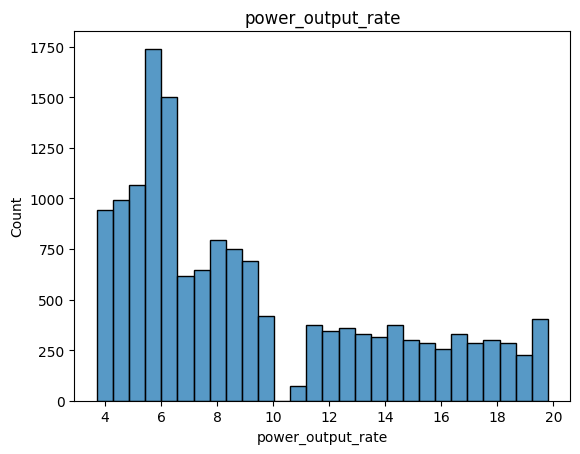

In [14]:
sns.histplot(dfs["power_output_rate"]).set_title("power_output_rate")

- DONE: plug + unplug needs to be specified in a local time + converted to UTC

# Calculate MOERs with no optimization

In [16]:
import os
os.chdir('/home/jennifer.badolato/watttime-python-client-aer-algo')
from watttime import WattTimeHistorical, WattTimeForecast
import pandas as pd
import optimizer.s3 as s3u
import pytz
import evaluation.eval_framework as evu
import seaborn as sns 
import matplotlib.pyplot as plt

In [17]:
# Example timezone as a stand in
[i for i in pytz.all_timezones if 'Eastern' in i]

['Canada/Eastern', 'US/Eastern']

In [18]:
region = "PJM_NJ"
time_zone = 'US/Eastern'
username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

actual_data = WattTimeHistorical(username, password)

In [21]:
s3 = s3u.s3_utils()
key = '20240713_1k_synth_users.csv'
generated_data = s3.load_csvdataframe(file=key)

In [19]:
def intervalize_power_rate(kW_value: float, convert_to_MW = True):
    five_min_rate = kW_value / 12
    if convert_to_MW:
        five_min_rate = five_min_rate / 1000
    else:
        five_min_rate
    return five_min_rate

In [22]:
moer_actuals = actual_data.get_historical_pandas(
    start=generated_data.plug_in_time.min(),
    end=generated_data.unplug_time.max(),
    region=region
)

In [23]:
generated_data["plug_in_time"] = pd.to_datetime(generated_data["plug_in_time"])
generated_data["MWh_fraction"] = generated_data["power_output_rate"].apply(intervalize_power_rate)
generated_data["number_intervals_drawing_power"] = generated_data.charged_kWh_actual / generated_data.power_output_rate * 60 / 5

In [24]:
def sum_moer_actuals(
    moer_data,
    time_zone,
    MWh_fraction,
    plug_in_time,
    number_conseq_intervals
    ):
    plug_in_time_utc=evu.convert_to_utc(plug_in_time, time_zone)
    index_lower_limit = moer_data[moer_data.point_time >= plug_in_time_utc].index[0]
    index_upper_limit = index_lower_limit + int(number_conseq_intervals)
    return sum(moer_data[index_lower_limit: index_upper_limit]["value"] * MWh_fraction)

In [25]:
generated_data["moer_actuals"] = generated_data.apply(
    lambda x: sum_moer_actuals(
        moer_actuals,
        time_zone,
        x.MWh_fraction,
        x.plug_in_time,
        x.number_intervals_drawing_power
        ),
        axis=1
        )

Text(0.5, 1.0, 'MOER Actuals in lbs of CO2')

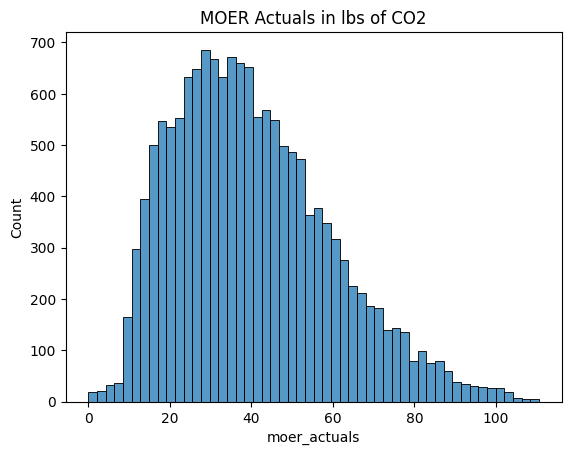

In [26]:
sns.histplot(generated_data["moer_actuals"]).set_title("MOER Actuals in lbs of CO2")